# Trabajo de Mentoria - DiploDatos

# Grupo A
    
Integrantes: 
    <li> Bruno Garcia
    <li> Nicolas Chiapello
    <li> Martin Peñas
        
        

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import missingno as msno

plt.rcParams['font.family'] = 'Tahoma'
sns.set_context('talk')

Realizamos el trabajo con un extracto de 1000 noticias del dataset original. Es a los fines de su reproducibilidad

In [ ]:
df_news = pd.read_csv("https://raw.githubusercontent.com/tinserrano/MentoriaDiplodatos/master/df_news_1000.csv")

In [ ]:
df_news.head(3)

,id,ticker,title,category,content,release_date,provider,url,article_id
0,248246,CTRN,Citi Trends CTRN Q1 Earnings Sales Miss S...,opinion,Citi Trends Inc NASDAQ CTRN began fiscal ...,2016-05-19,Zacks Investment Research,https://www.investing.com/analysis/citi-trends...,200130894
1,319341,TGT,Wal Mart profit beats expectations stock jumps,news,By Nathan Layne Reuters Wal Mart Stores In...,2016-05-19,Reuters,https://www.investing.com/news/stock-market-ne...,403085
2,246512,AMED,These 5 Low Leverage Stocks Are Safe Bets,opinion,Leverage refers to an investment strategy that...,2019-03-07,Zacks Investment Research,https://www.investing.com/analysis/these-5-low...,200395847


###*Analizamos datos faltantes*

Previo a trabajar con las consignas dadas, observamos que tenemos datos faltantes dentro de la columna `content`, por lo que quitaremos las filas que no poseen contenido.



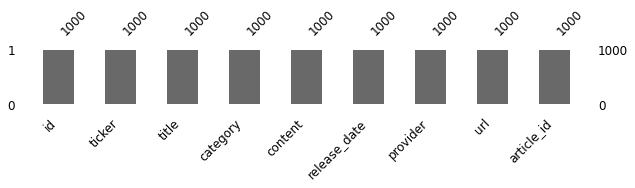

In [ ]:
msno.bar(df_news, figsize=(10,1), fontsize=12)

In [ ]:
df_news = df_news.dropna()

###*Analizamos noticias repetidas*

Analizamos los valores de las columnas `provider`, `title` y `content`. Encontramos noticias repetidas en la columna `content`; el caso que más repeticiones posee, observamos que es exactamente la misma noticia, pero con diferente url y fecha de emisión.

In [ ]:
df_news.content.value_counts()

EquitiesAsian markets traded mixed ahead of the weekend s European summit   The Nikkei closed down fractionally  and the ASX 200 edged down  1    Korea s Kospi rallied 1 8   as LG Display surged 7 8  despite posting a loss   In China  the Hang Seng rose  2   while the Shanghai Composite slipped  6  to a 31 month low European indexes rallied  on hopes for a European bailout deal   The DAX jumped 3 6   the CAC40 gained 2 8   and the FTSE climbed 1 9  US markets continued the rally  as the Dow soared 267 points to 11809   The Nasdaq rose 1 5  and the S P 500 gained 1 9   while the VIX dropped 10  to 31 32 Dow Soars 267 PointsHoneywell shares rallied 5 8  after reporting strong earnings and lifting its outlook   GE shares slipped 1 9  on earnings that were in line with forecasts Seagate share jumped 28  on expectations the hard drive maker won t suffer as much as rival Western Digital from the floods in Asia CurrenciesThe Japanese briefly touched a record high against the dollar in the ear

In [ ]:
df_news = df_news.drop_duplicates(subset = ["content"])

#Analisis y Curacion

##- Normalizar palabras de los documentos de noticias.
* Títulos y contenido.
* Quitar signos de puntuación
* Pasar palabras a minúsculas
* Eliminar Stop words
* Lematizar palabras
* Etiquetar Part of Speech.

Observar características de interés para nuestro problema en particular. No perder información valiosa y ver en qué palabras y tipo de palabras encontramos mayor información de interés para la clasificación del ticker y del "sentimiento" ya sea positivo o negativo.

###*Normalizamos por pipeline*

####Word tokenizer

Generamos los tokens a partir de los espacios en blanco y a partir de los saltos de línea "\n".

In [ ]:
from nltk.tokenize import WhitespaceTokenizer

#Generamos los tokens a partir de espacios en blanco y de saltos de línea
def p_word_tokenizer(text_string):    
    return WhitespaceTokenizer().tokenize(text_string)

####Only letters

Pasamos palabras a minúsculas, removemos símbolos y números. Removemos todos los símbolos y números ya que observamos luego de no haberlos sacado en un comienzo que estos caracteres solo terminaban generando ruido, y no aportando información relevante para nuestro análisis.

In [ ]:
import re

#Pasamos palabras a minúsculas, removemos símbolos y números
def p_only_letters(text_list):

    #Pasa todo a minúscula y remueve todos los símbolos excepto el guión bajo
    clean_text_list = [re.sub('[\W]+', '', word.lower()) for word in text_list]

    #Remueve números
    clean_text_list = [re.sub(r"\d+", "", word) for word in clean_text_list]

    #Elimina los tokens vacíos
    for i in range(clean_text_list.count('')):
        clean_text_list.remove('')

    return clean_text_list

####Remove stopwords

In [ ]:
import nltk.corpus
from nltk.corpus import stopwords
nltk.download('stopwords')

#Eliminamos stopwords
def p_remove_stopwords(text_list):
    stop = stopwords.words('english')
    return [word for word in text_list if word not in (stop)]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


####Word lemmatizer

El proceso de lematizado tiene por objetivo reducir las palabras de su forma flexionada (ej: comiendo, amigos) a su forma raíz (comer, amigo).

Aquí lemmatizamos para todos los tipos de palabras: verbo, sustantivo, adjetivo y adverbio. Por defecto el método lo hace solo para sustantivos (pos="n") por eso por ejemplo no transforma verbos como raining a rain, y si no se aplica de esta forma hay muchas palabras que siguen quedando en su forma flexionada; por ello, lo realizamos de esta forma.

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

#Lemmatizamos para todos los tipos de palabras: verbo, sustantivo, adjetivo y adverbio.
def p_word_lemmatizer(text_list):
    lemm_text_list = [WordNetLemmatizer().lemmatize(word, pos="n") for word in text_list]
    lemm_text_list = [WordNetLemmatizer().lemmatize(word, pos="v") for word in lemm_text_list]
    lemm_text_list = [WordNetLemmatizer().lemmatize(word, pos="a") for word in lemm_text_list]
    lemm_text_list = [WordNetLemmatizer().lemmatize(word, pos="r") for word in lemm_text_list]
    return lemm_text_list

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


####Pipeline

Realizamos una función de transformación para "pipelinizar" aquellas funciones que se usarán en el pipeline:

In [ ]:
from sklearn.preprocessing import FunctionTransformer

#Función para transformar las funciones que se usarán en el pipeline.
def pipelinize(function, active=True):

    def list_comprehend_a_function(list_of_texts, active=True):
        if active:
            return [function(i) for i in list_of_texts]
        else: # if it's not active, just pass it right back
            return list_of_texts

    return FunctionTransformer(list_comprehend_a_function, validate=False, kw_args={'active':active})

Aquí utilizamos por primera vez el pipeline para aplicar las funciones de normalización en el contenido y el título de cada noticia de esta forma más automatizada:

In [ ]:
from sklearn.pipeline import Pipeline

estimators = [('p_word_tokenizer', pipelinize(p_word_tokenizer)),
              ('p_only_letters', pipelinize(p_only_letters)),
              ('p_remove_stopwords', pipelinize(p_remove_stopwords)),
              ('p_word_lemmatizer', pipelinize(p_word_lemmatizer))]
pipe = Pipeline(estimators)

new_df_news = df_news.copy()
new_df_news['title_tokens'] = pipe.transform(new_df_news.title)
new_df_news['content_tokens'] = pipe.transform(new_df_news.content)

In [ ]:
new_df_news[:10]

,id,ticker,title,category,content,release_date,provider,url,article_id,title_tokens,content_tokens
123391,344906,CME,Gold surges more than 1 above 1 100 amid so...,news,Investing com Gold surged by more than 1 5 ...,2016-01-20,Investing.com,https://www.investing.com/news/commodities-new...,380954,"[gold, surge, amid, soft, u, inflation, data]","[invest, com, gold, surge, wednesday, rise, ou..."
130405,351920,ARWR,6 Stocks To Watch AMRN ARWR CLVS EOLS OST...,opinion,It was a mixed session on Wall Street on Wedne...,2019-02-27,Harry Boxer,https://www.investing.com/analysis/amrn-arwr-c...,200393269,"[stock, watch, amrn, arwr, clvs, eols, ostk, r...","[mix, session, wall, street, wednesday, big, d..."
87035,308550,NFLX,Are Options Traders Betting On A Big Move In S...,opinion,Investors in Surmodics Inc NASDAQ SRDX n...,2019-06-19,Zacks Investment Research,https://www.investing.com/analysis/are-options...,200433025,"[option, trader, bet, big, move, surmodics, sr...","[investor, surmodics, inc, nasdaq, srdx, need,..."
139322,360837,GOOGL,Singapore Morning Report USD Powers On Gold ...,opinion,Economic data of the day Singapore Time \n\n1...,2015-07-20,Saxo Bank,https://www.investing.com/analysis/singapore-m...,258853,"[singapore, morning, report, usd, power, gold,...","[economic, data, day, singapore, time, eur, ge..."
203022,424538,GM,Chinese automakers kick tires at FCA but any ...,news,HONG KONG Reuters Geely Automobile Holding...,2017-08-16,Reuters,https://www.investing.com/news/stock-market-ne...,519332,"[chinese, automaker, kick, tire, fca, deal, fa...","[hong, kong, reuters, geely, automobile, hold,..."
110070,331585,HMC,Nikkei hits 4 wk closing high on yen earnings...,news,TOKYO Oct 26 Reuters The Nikkei average h...,2009-10-26,Reuters,https://www.investing.com/news/equities-news/n...,97399,"[nikkei, hit, wk, close, high, yen, earn, hope]","[tokyo, oct, reuters, nikkei, average, hit, hi..."
42022,263537,BAC,U S SEC awards Merrill Lynch whistleblowers a...,news,By Pete Schroeder WASHINGTON Reuters The U...,2018-03-19,Reuters,https://www.investing.com/news/stock-market-ne...,1348860,"[u, sec, award, merrill, lynch, whistleblower,...","[pete, schroeder, washington, reuters, u, secu..."
42067,263582,BAC,Goldman In Hot Water Libyan Fund May Appeal R...,opinion,The Goldman Sachs Group Inc NYSE GS has ...,2016-11-07,Zacks Investment Research,https://www.investing.com/analysis/goldman-in-...,200163274,"[goldman, hot, water, libyan, fund, may, appea...","[goldman, sachs, group, inc, nyse, g, yet, acc..."
216581,438097,VZ,Wednesday Higher,opinion,The Hoot \nActionable ideas for the busy trad...,2015-06-10,The Night Owl Trader,https://www.investing.com/analysis/wednesday-h...,254538,"[wednesday, high]","[hoot, actionable, idea, busy, trader, deliver..."
93398,314913,INTC,Earnings Galore Know These Levels,opinion,Wednesday morning the S P 500 Index e mini fu...,2012-10-18,Nicholas Santiago,https://www.investing.com/analysis/earnings-ga...,140222,"[earn, galore, know, level]","[wednesday, morning, p, index, e, mini, future..."


###*Etiquetamos Part of Speech*

Por último realizamos un etiquetado Part of Speech que consiste en categorizar las palabras lingüísticamente.

In [ ]:
nltk.download('averaged_perceptron_tagger')

def word_pos_tagger(text):
    pos_tagged_text = nltk.pos_tag(text)
    return pos_tagged_text

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
new_df_news['content_tokens_tagged'] = new_df_news['content_tokens'].apply(lambda x: word_pos_tagger(x))
new_df_news['title_tokens_tagged'] = new_df_news['title_tokens'].apply(lambda x: word_pos_tagger(x))
new_df_news[:5]

,id,ticker,title,category,content,release_date,provider,url,article_id,title_tokens,content_tokens,content_tokens_tagged,title_tokens_tagged
123391,344906,CME,Gold surges more than 1 above 1 100 amid so...,news,Investing com Gold surged by more than 1 5 ...,2016-01-20,Investing.com,https://www.investing.com/news/commodities-new...,380954,"[gold, surge, amid, soft, u, inflation, data]","[invest, com, gold, surge, wednesday, rise, ou...","[(invest, JJS), (com, NN), (gold, NN), (surge,...","[(gold, NN), (surge, NN), (amid, IN), (soft, J..."
130405,351920,ARWR,6 Stocks To Watch AMRN ARWR CLVS EOLS OST...,opinion,It was a mixed session on Wall Street on Wedne...,2019-02-27,Harry Boxer,https://www.investing.com/analysis/amrn-arwr-c...,200393269,"[stock, watch, amrn, arwr, clvs, eols, ostk, r...","[mix, session, wall, street, wednesday, big, d...","[(mix, NN), (session, NN), (wall, NN), (street...","[(stock, NN), (watch, NN), (amrn, NN), (arwr, ..."
87035,308550,NFLX,Are Options Traders Betting On A Big Move In S...,opinion,Investors in Surmodics Inc NASDAQ SRDX n...,2019-06-19,Zacks Investment Research,https://www.investing.com/analysis/are-options...,200433025,"[option, trader, bet, big, move, surmodics, sr...","[investor, surmodics, inc, nasdaq, srdx, need,...","[(investor, NN), (surmodics, NNS), (inc, VBP),...","[(option, NN), (trader, NN), (bet, NN), (big, ..."
139322,360837,GOOGL,Singapore Morning Report USD Powers On Gold ...,opinion,Economic data of the day Singapore Time \n\n1...,2015-07-20,Saxo Bank,https://www.investing.com/analysis/singapore-m...,258853,"[singapore, morning, report, usd, power, gold,...","[economic, data, day, singapore, time, eur, ge...","[(economic, JJ), (data, NNS), (day, NN), (sing...","[(singapore, RB), (morning, NN), (report, NN),..."
203022,424538,GM,Chinese automakers kick tires at FCA but any ...,news,HONG KONG Reuters Geely Automobile Holding...,2017-08-16,Reuters,https://www.investing.com/news/stock-market-ne...,519332,"[chinese, automaker, kick, tire, fca, deal, fa...","[hong, kong, reuters, geely, automobile, hold,...","[(hong, RB), (kong, JJ), (reuters, NNS), (geel...","[(chinese, JJ), (automaker, NN), (kick, NNP), ..."


Creemos que pueden ser de interés para la clasificación del "sentimiento" de la noticia ya sea positivo o negativo, las palabras de tipo adjetivos. Ya que nos aportarían una información importante para poder deducir un sentimiento general de la noticia, a partir de cuantos adjetivos positivos/negativos tiene la misma y cuale son más abundantes por ejemplo.

##- Graficar frecuencia de palabras
* Graficar Frecuencia de palabras en noticias (* Lo realizamos a partir del count vectorizer, el gráfico de barras de las 15 más frecuentes)
* Graficar Frecuencia de palabras en noticias por provider
* Graficar Frecuencia de palabras en noticias por ticker

¿Que conclusiones podemos encontrar al ver las frecuencias de las palabras?

###*Distribución de caracteres en las noticias*

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribucion de cantidad de caracteres en contenidos')

findfont: Font family ['Tahoma'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Tahoma'] not found. Falling back to DejaVu Sans.


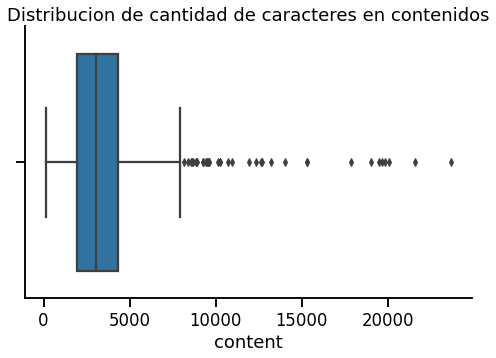

In [ ]:
#Graficamos la distribución de cantidad de caracteres en noticias sin haber normalizado.
caracteres_news = new_df_news.content.apply(len)
plt.figure(figsize=(8, 5))
sns.boxplot(caracteres_news)
sns.despine()
plt.title("Distribucion de cantidad de caracteres en contenidos")

In [ ]:
#La media de caracteres por noticia sin haber normalizado.
caracteres_news.values.mean().round()

3464.0

In [ ]:
#La media de caracteres por noticia luego de normalizar los textos.
caracteres_news = new_df_news.content_tokens.apply(str).apply(len)
caracteres_news.values.mean().round()

3281.0

Observamos que más del 75% de las noticias tienen menos de 5K caracteres, y son muy pocas (valores atípicos) las noticias que son de más de 10K caracteres.

La media de la cantidad de caracteres por noticia es de 3455. Y vemos que en promedio con el proceso de normalización aplicado anteriormente se eliminan por noticia 156 caracteres.

###*Gráficamos palabras por tickers*

In [ ]:
# Funcion para tomar muestra de contenidos
def sample_text_from_col(df, n=1000,
                         text_col='content'):
  """Extract a sample of text from column"""
  if n > len(df):
    n = len(df)
  return '\n'.join(df.sample(n)[text_col].values)

In [ ]:
# Tomar muestras de tickers mas frecuentes
unique_tickers = ['AAPL', 'MSFT', 'BAC', 'AMZN', 'NWSA','GOOGL']
text_samples_for_ticker = {
    ticker: sample_text_from_col(df_news[df_news.ticker == ticker])
    for ticker in unique_tickers
    if isinstance(ticker, str)
}
list(text_samples_for_ticker.keys())

['AAPL', 'MSFT', 'BAC', 'AMZN', 'NWSA', 'GOOGL']

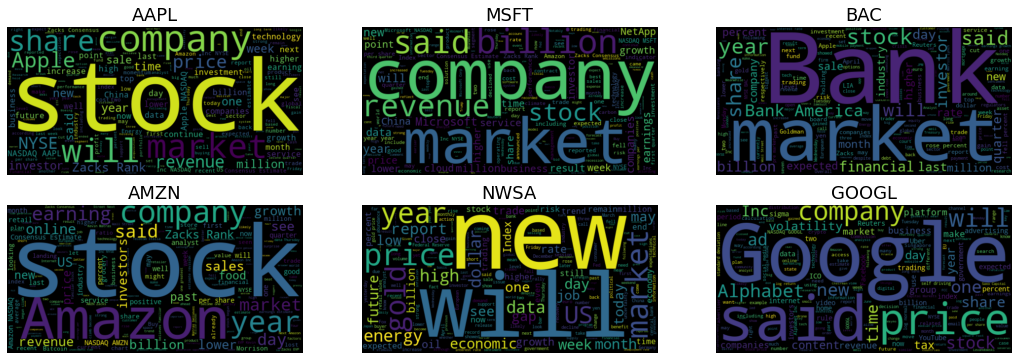

In [ ]:
# Create general layout tickers

from wordcloud import WordCloud
import math

n_cols = 3
n_rows = math.ceil(len(text_samples_for_ticker) / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 6))
for i, (ticker, text_sample) in enumerate(text_samples_for_ticker.items()):
  wc = WordCloud(width=600, height=300, max_font_size=200)\
      .generate(text_sample)
  row = math.floor(i / n_cols)
  col = i % n_cols
  ax = axs[row, col]
  ax.imshow(wc, interpolation='bilinear')
  ax.axis("off")
  ax.set_title(ticker)

###*Gráficamos palabras por providers*

In [ ]:
provider_mas_freq = list(df_news.provider.value_counts()[:6].index)

In [ ]:
#Sample providers mas frecuentes
unique_providers = provider_mas_freq
text_samples_for_provider = {
    provider: sample_text_from_col(df_news[df_news.provider == provider])
    for provider in unique_providers
    if isinstance(provider, str)
}
list(text_samples_for_provider.keys())

['Zacks Investment Research',
 'Reuters',
 'Investing.com',
 'Seeking Alpha',
 'Bloomberg',
 'The Gold Report']

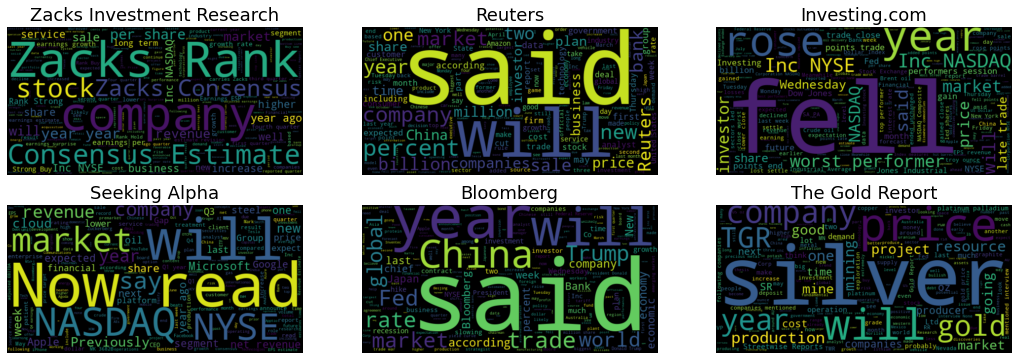

In [ ]:
# Create general layout provider

n_cols = 3
n_rows = math.ceil(len(text_samples_for_provider) / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 6))
for i, (provider, text_sample) in enumerate(text_samples_for_provider.items()):
  wc = WordCloud(width=600, height=300, max_font_size=200)\
      .generate(text_sample)
  row = math.floor(i / n_cols)
  col = i % n_cols
  ax = axs[row, col]
  ax.imshow(wc, interpolation='bilinear')
  ax.axis("off")
  ax.set_title(provider)

##- Preparamos datasets para aprendizaje supervisado

###Noticias Financieras:
* Guardamos los documentos en el nuevo CSV con palabras pre-procesadas
* Preparar un bag of words utilizando:
  * CountVectorizer
  * TfidfVectorizer
  * Observar y comentar las diferencias que encontremos, se pueden usar otros que no estén especificados aquí.
* Crear Pipeline para preparar un documento, para pre-procesar, y realizar un CountVectorizer.

###***Count Vectorizer***

Luego del proceso de curación de los textos, aplicamos el método Count Vectorizer para obtener un bag of words con el conteo de las palabras que aparecen en cada noticia. Este método cuenta las palabras que se encuentran en un texto, obteniendo así una representación de frecuencias.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

#Realizamos el Count Vectorizer
def count_vectorizer_corpus(list_text_list):
    list_text = [str(text_list) for text_list in list_text_list]
    vocab_size = 500  #Only 500 most frequent words
    cv = CountVectorizer(max_features=vocab_size)
    cv.fit(list_text)
    cv_array = cv.transform(list_text).toarray()
    cv_word_list = cv.get_feature_names()
    cv_bag_of_words = pd.DataFrame(data=cv_array, columns=cv_word_list)
    return cv_bag_of_words

In [ ]:
cv_bag_of_words = count_vectorizer_corpus(new_df_news.content_tokens.values)
cv_word_list = cv_bag_of_words.columns
cv_bag_of_words

,aapl,accord,account,acquisition,across,action,activity,add,adjust,advance,ago,ahead,air,almost,already,also,amazon,america,american,among,analysis,analyst,announce,annual,another,anticipate,apple,april,area,around,asset,average,back,bad,balance,bank,barrel,base,basis,beat,...,top,total,track,trade,trader,trend,trump,tuesday,turn,two,unit,unite,upside,usd,use,value,vehicle,view,volatility,volume,wall,want,way,weak,wednesday,week,well,whether,without,witness,work,world,worth,would,write,year,yet,yield,york,zacks
0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,3,0,0,0,0,0,1,0,2,1,0,0,0,0,1,1,0,0,0,0,1,0,0,3,0,...,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,1,0,0,0,3,3,0,0,0,0,0,1,0,0,0,4,0,1,1,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,1,1,0,6,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,2,0,0,5,4,0,0,0,0,0,0,0,0,0,1,0,0,0,7,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3
3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,2,0,0,1,0,0,0,0,0,1,1,0,2,0,0,4,0,3,0,0,...,0,0,1,13,1,1,0,0,0,0,0,0,0,2,0,0,0,2,3,0,0,0,0,0,0,2,0,1,1,0,0,0,0,0,0,4,0,0,0,0
4,0,0,0,3,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,...,0,0,2,1,0,0,1,0,1,1,0,3,0,0,0,0,0,0,0,0,1,2,0,0,4,1,2,2,1,0,0,1,0,3,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,8,0,1,0,1,0,0,0,0,3,0,0,0,0
995,0,0,0,0,0,1,0,0,0,0,0,0,4,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,1,0,0,...,0,0,0,0,0,0,6,5,0,3,0,2,0,0,4,0,0,0,0,0,0,0,3,0,0,1,1,0,0,0,0,1,0,7,0,3,0,0,0,0
996,0,0,0,1,2,0,0,0,0,0,0,0,1,0,1,2,0,0,9,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,1,0,0,1,0,3,0,0,0,3
997,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,2,0,4,0,0,2,0,0,0,1,...,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3,0,0,0,0,0,1,0,0,0,3,0,0,0,0


En las columnas se encuentran por separado como tokens todas las palabras existentes en el corpus (la suma de todos los textos), y cada fila representa un texto, en este caso el contenido de una noticia puntual.

Los vectores de conteo pueden ser útiles para comprender el tipo de texto por la frecuencia de las palabras que contiene, como podemos observar en la tabla.

Y a partir de lo obtenido, de la siguiente forma podemos mostrar la frecuencia de cada palabra en todo el corpus. En la tabla y el gráfico de abajo mostramos las 15 más frecuentes y su frecuencia.

In [ ]:
frequency = []
for col in cv_word_list:
  frequency.append(cv_bag_of_words[col].sum())

cv_words_frequency = pd.DataFrame( data = {'frequency': frequency}, index=cv_word_list ).sort_values('frequency', ascending=False)
cv_words_frequency.head(15)

,frequency
year,4086
company,3407
stock,2868
earn,2539
zacks,2439
quarter,2148
market,2144
share,1935
say,1800
price,1663


Text(0.5, 0, 'Words')

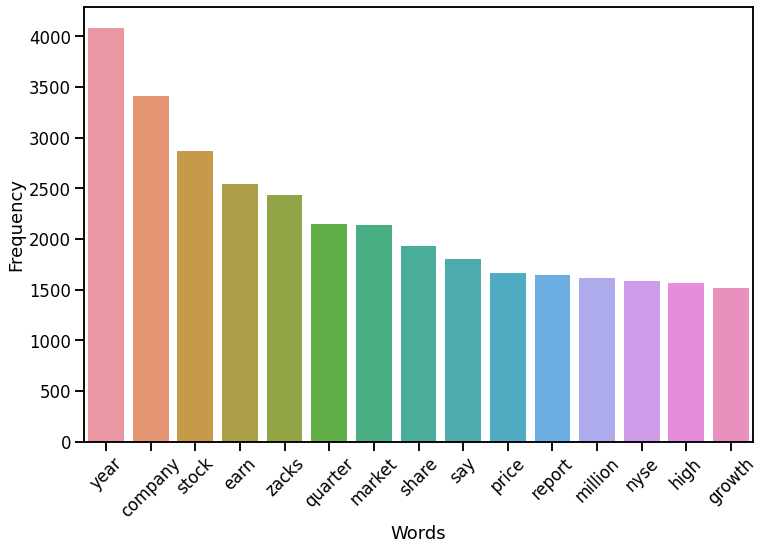

In [ ]:
#Graficamos Frecuencia de palabras en noticias
cv_words_freq_top = cv_words_frequency.head(15)

fig = plt.figure(figsize=(12,8))
sns.barplot(x=cv_words_freq_top.index, y=cv_words_freq_top.frequency)

plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.xlabel("Words")

Podemos observar que las palabras que más se repiten no necesariamente nos aportan mucha información para nuestro objetivo. Year, company, stock son palabras que no nos dicen mucho de la noticia y que es esperable que aparezcan en la gran mayoría. Por otro lado vimos que se repite mucho zacks, buscamos la palabra y es una empresa de investigación de inversiones, podemos deducir que en muchas noticias se hace referencia a ella.

###***TF-IDF Vectorizer (Term Frequency - Inverse Document Frequency)***

El método TF-IDF Vectorizer combina 2 procedimientos: frecuencia de término (tiene en cuenta solo la noticia analizada) y frecuencia de documento inversa (que tiene en cuenta la aparición de esas palabras en el resto de noticias).

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer as tf_idf

#Realizamos el TF-IDF Vectorizer
def tfidf_vectorizer_corpus(list_text_list, tfidf):
    list_text = [str(text_list) for text_list in list_text_list]
    tfidf.fit(list_text)
    tfidf_array = tfidf.transform(list_text).toarray()
    tfidf_word_list = tfidf.get_feature_names()
    tfidf_bag_of_words = pd.DataFrame(data=tfidf_array, columns=tfidf_word_list)
    return tfidf_bag_of_words

In [ ]:
#Ponemos el tf_idf afuera de la función porque después lo necesitamos para obtener el idf
vocab_size = 500  #Only 500 most frequent words
tfidf = tf_idf(max_features=vocab_size, norm = None)

tfidf_bag_of_words = tfidf_vectorizer_corpus(new_df_news.content_tokens.values, tfidf)
tfidf_word_list = tfidf_bag_of_words.columns
tfidf_bag_of_words

,aapl,accord,account,acquisition,across,action,activity,add,adjust,advance,ago,ahead,air,almost,already,also,amazon,america,american,among,analysis,analyst,announce,annual,another,anticipate,apple,april,area,around,asset,average,back,bad,balance,bank,barrel,base,basis,beat,...,top,total,track,trade,trader,trend,trump,tuesday,turn,two,unit,unite,upside,usd,use,value,vehicle,view,volatility,volume,wall,want,way,weak,wednesday,week,well,whether,without,witness,work,world,worth,would,write,year,yet,yield,york,zacks
0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,3.047943,0.000000,0.000000,2.720369,0.000000,0.000000,0.00000,4.473069,0.0,0.0,0.000000,0.000000,0.000000,2.386294,0.000000,6.526729,2.65026,0.0,0.0,0.000000,0.000000,2.500584,2.714798,0.000000,0.000000,0.0,0.0,2.358679,0.0,0.000000,8.612408,0.00000,...,0.000000,0.000000,0.000000,3.527139,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,6.257264,3.333044,0.000000,3.047943,0.000000,0.000000,0.000000,8.631952,5.982757,0.000000,0.000000,0.0000,0.000000,0.00000,2.474033,0.0,0.000000,0.0,5.242438,0.0,3.419119,3.024953,0.000000
1,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.937942,0.000000,0.000000,0.000000,3.128632,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,6.838238,2.500584,0.000000,0.000000,2.301953,0.0,0.0,0.000000,0.0,2.090644,0.000000,0.00000,...,0.000000,0.000000,0.000000,1.763570,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,9.514670,3.047943,2.725972,2.737271,0.000000,17.263904,1.994252,3.924669,0.000000,0.0000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
2,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.491023,0.0,0.0,0.000000,0.000000,3.375156,7.158883,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,2.090644,0.000000,0.00000,...,4.010244,0.000000,0.000000,8.817848,14.153230,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2.491655,0.0,0.0,0.000000,23.331310,0.000000,0.000000,0.000000,2.737271,0.000000,0.000000,1.994252,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,5.801837
3,0.0,0.0,2.771957,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.128632,2.65026,1.491023,0.0,0.0,0.000000,0.000000,6.750312,0.000000,0.000000,3.263364,0.00000,0.0,0.0,0.000000,0.000000,2.500584,2.714798,0.000000,4.603906,0.0,0.0,9.434717,0.0,6.271932,0.000000,0.00000,...,0.000000,0.000000,3.154165,22.926405,3.538307,2.537117,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,7.234592,0.000000,0.0,0.0,6.257264,9.999133,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.988505,0.000000,3.263364,2.9951,0.000000,0.00000,0.000000,0.0,0.000000,0.0,5.242438,0.0,0.000000,0.000000,0.000000
4,0.0,0.0,0.000000,9.411212,0.000000,0.000000,0.0,2.269401,0.000000,0.000000,2.500584,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000,2.987774,0.000000,0.000000,2.546463,0.000000,0.00000,0.0,0.0,3.216407,0.000000,0.000000,2.714798,0.000000,0.000000,0.0,0.0,0.000000,0.0,2.090644,0.000000,0.00000,...,0.000000,0.000000,6.308330,1.763570,0.000000,0.000000,3.396896,0.000000,3.145581,2.142564,0.0,8.497744,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,3.047943,5.451943,0.000000,0.000000,11.509269,1.994252,3.924669,6.526729,2.9951,0.000000,0.00000,2.474033,0.0,6.307861,0.0,1.310610,0.0,0.000000,3.024953,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

TF-IDF se basa en la lógica de que las palabras que son demasiado abundantes en el corpus y las palabras que son demasiado raras no son estadísticamente importantes para encontrar un patrón. El factor logarítmico en tfidf penaliza matemáticamente las palabras que son demasiado abundantes o demasiado raras en el corpus dándoles puntuaciones bajas en tfidf.

Un valor más alto de tfidf significa una mayor importancia de las palabras en el corpus, mientras que los valores más bajos representan una menor importancia.

Realizamos un promedio sumando los valores tfidf de cada palabra en cada noticia y dividiéndolo por la cantidad de noticias en las que aparece la palabra en cuestión. Pensamos esto como una forma de obtener la relevancia de la palabra en el corpus, distinta a solo tener en cuenta el valor idf:

In [ ]:
#Ejemplo con year de como funciona:
cantidad = (tfidf_bag_of_words[tfidf_bag_of_words.year.values != 0]).year.size
print(cantidad)
(tfidf_bag_of_words.year.values.sum())/cantidad

732


7.315779688541195

In [ ]:
importance = []
for col in tfidf_word_list:
  cantidad = (tfidf_bag_of_words[tfidf_bag_of_words[col].values != 0])[col].size
  importance.append(tfidf_bag_of_words[col].sum()/cantidad)

tfidf_words_importance = pd.DataFrame( data = {'importance': importance}, index=cv_word_list ).sort_values('importance', ascending=False)
tfidf_words_importance.head(15)

,importance
esp,21.623944
mine,19.179375
silver,17.524561
score,15.483520
interview,15.099060
game,14.514419
percent,14.470102
gold,14.454358
etf,12.658451
dividend,12.585512


Teniendo en cuenta solo idf:

In [ ]:
tfidf_words_idf = pd.DataFrame( data = {'idf': tfidf.idf_}, index=cv_word_list ).sort_values('idf', ascending=False)
tfidf_words_idf.head(15)

,idf
silver,4.218876
interview,4.194183
mine,4.123566
esp,4.101093
performer,4.057608
game,4.036554
metal,3.995732
goldman,3.975930
google,3.847312
loan,3.847312


Por último creemos que quizás una forma interesante de observar los resultados de tfidf a nivel de corpus, sería eliminar las palabras que tienen poca relevancia en cada noticia, y una vez hecho esto ahí sí realizar una sumatoria a nivel de corpus para cada palabra (columna), los resultados quizás reflejen mejor las palabras de mayor importancia a nivel corpus.

###*Diferencias*

Entendemos que para obtener un bag of words de las palabras más relevantes TF-IDF es mejor que Count Vectorizers porque no solo analiza la frecuencia de las palabras presentes en la noticia, si no que también como esas palabras se repiten en el corpus, y teniendo en cuenta ambos nos proporciona una representación numérica que nos indica la importancia de cada palabra en la noticia.

Entonces luego si queremos podemos eliminar las palabras que son menos importantes para el análisis, lo que hace que la construcción del modelo sea menos compleja al reducir las dimensiones de entrada.

###***Word Cloud***

Función genérica para generar nube de palabras a partir de un diccionario de frecuencias de palabras.


In [ ]:
#Función para generar nube de palabras a partir de un diccionario de frecuencias de palabras.
def word_cloud(dict_word_freq):
    #Generating wordcloud. Relative scaling value is to adjust the importance of a frequency word.
    #See documentation: https://github.com/amueller/word_cloud/blob/master/wordcloud/wordcloud.py
    wordcloud_cv = WordCloud(width=900,height=500,max_words=250,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(dict_word_freq)
    plt.figure(figsize=(14,12))
    plt.imshow(wordcloud_cv, interpolation='bilinear')
    plt.axis("off")
    plt.show()

####Word Cloud CountVectorizer

Función para llamar word_cloud a partir del bag of words de count vectorizer. Funciona para un df de bag_of_words con una única fila de una noticia como para el corpus entero.

In [ ]:
#Función para llamar word_cloud a partir del bag of words de count vectorizer.
#Funciona para un df de bag_of_words con una única fila de una noticia como para el corpus entero.
def p_word_cloud_cv(bag_of_words):
    word_list = bag_of_words.columns
    freq_list = [bag_of_words[col].sum() for col in word_list]
    dict_word_freq = dict(zip(word_list,freq_list))
    word_cloud(dict_word_freq)

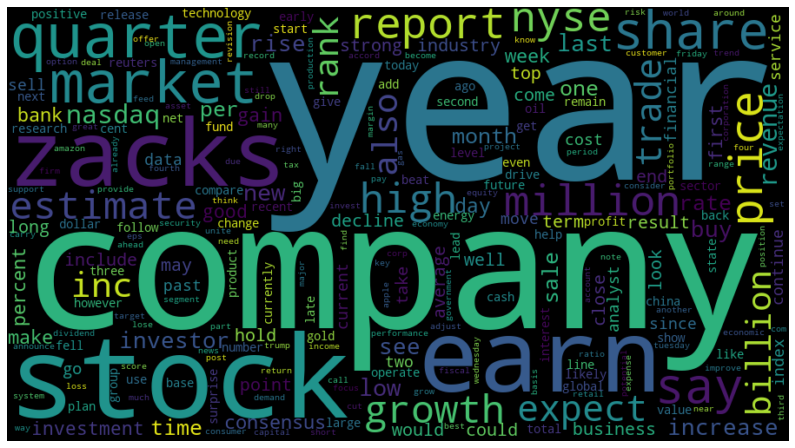

In [ ]:
p_word_cloud_cv(cv_bag_of_words)

Como comentamos anteriormente, podemos observar que las palabras que más se repiten no necesariamente aportan mucha información para nuestro análisis. Year, company, stock son palabras que no nos dicen mucho de la noticia y que es esperable que aparezcan en la gran mayoría. Por otro lado vimos que se repite mucho zacks, buscamos la palabra y es una empresa de investigación de inversiones, podemos deducir que en muchas noticias se hace referencia a ella.

####WordCloud TF-IDF

Función para llamar word_cloud a partir del bag of words de tfidf vectorizer. Funciona para un df de bag_of_words con una única fila de una noticia como para el corpus entero.

Ordena solo por importancia (solo idf), creemos que este es el que mejor refleja el resultado de la bag of words del vectorizado por tfidf.

In [ ]:
#Función para llamar word_cloud a partir del bag of words de tfidf vectorizer.
#Ordena solo por idf, por importancia.
#Funciona para un df de bag_of_words con una única fila de una noticia como para el corpus entero.
def word_cloud_tfidf_idf(bag_of_words, tfidf):
    word_list = bag_of_words.columns
    idf_list = tfidf.idf_
    dict_word_freq = dict(zip(word_list,idf_list))
    word_cloud(dict_word_freq)

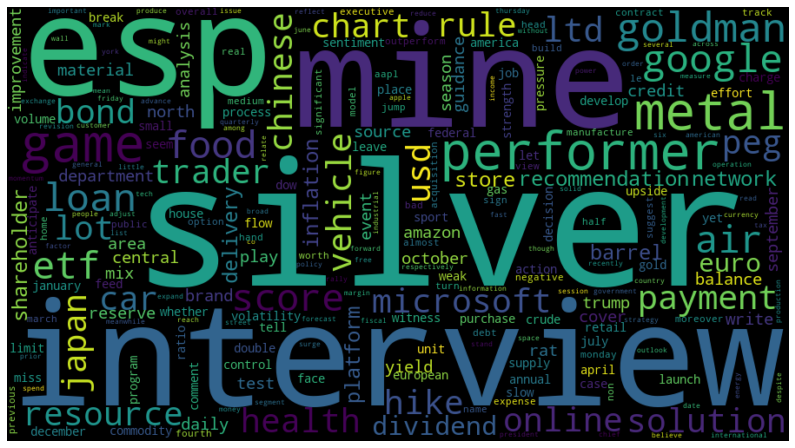

In [ ]:
word_cloud_tfidf_idf(tfidf_bag_of_words, tfidf)

En esta nube de palabras podemos observar que si aparecen palabras que pueden resultar más interesantes para el análisis. Y lo otro es que al estar utilizando samples del df vemos que usando el método tfidf si varían las palabras más relevantes que se observan de un sample a otro sample, esto no ocurre con cv, donde casi siempre son las mismas.

Por promedio desarrollado y explicado en tfidf:

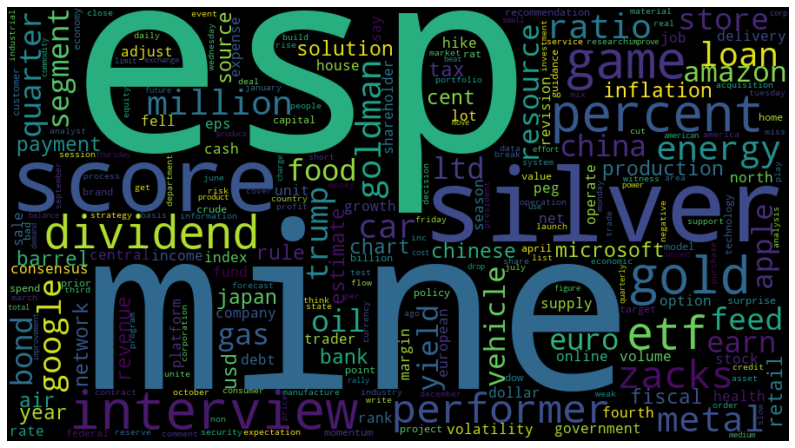

In [ ]:
#Para llamar word_cloud a partir del bag of words de tfidf vectorizer.
#Ordena a partir del promedio desarrollado anteriormente, que tiene en cuenta tanto frecuencia como importancia.
#Funciona para un df de bag_of_words con una única fila de una noticia como para el corpus entero.
tfidf_dict_word_freq = dict(zip(tfidf_words_importance.index,tfidf_words_importance.importance))
word_cloud(tfidf_dict_word_freq)

Observamos que las palabras más relevantes a partir de este análisis son similares a cuando tenemos en cuenta sólo el valor idf, pero lógicamente existe una variación.

##- Pipeline

Las funciones que se pueden utilizar para el pipeline las indicamos a lo largo del documento con una p al comienzo, que son todas las necesarias para realizar la normalización de las palabras, correr el count vectorizer para obtener el bag of words y graficar la nube de palabras. Todo realizado para cada noticia por separado, pudiendo realizarlo para una en particular o para todas las del corpus.

####Count Vectorizer (bag of words) para pipeline

Este count vectorizer es para obtener el bag of words de cada noticia por separado. Es el que se puede utilizar en el pipeline que desarrollamos.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

#Realizamos el Count Vectorizer
def p_count_vectorizer(text_list):
    text_list = str(text_list)
    vocab_size = 500  #Only 500 most frequent words
    cv = CountVectorizer(max_features=vocab_size)
    cv.fit([text_list])
    cv_array = cv.transform([text_list]).toarray()
    cv_word_list = cv.get_feature_names()
    cv_bag_of_words = pd.DataFrame(data=cv_array, columns=cv_word_list)
    return cv_bag_of_words

Corremos todas las funciones para obtener un bag of words de la primer noticia del sample, algo similar a lo que realiza el pipeline:

In [ ]:
p_count_vectorizer(p_word_lemmatizer(p_remove_stopwords(p_only_letters(p_word_tokenizer(new_df_news.content.values[0])))))

,adjust,adjustment,ahead,also,analyst,annual,another,appreciate,approximately,around,asset,associate,bank,basis,basket,bear,bearish,become,beyond,bridgewater,broad,bureau,care,census,central,ceo,chance,cme,cnbc,com,come,comex,committee,commodity,comparison,compete,consensus,considerably,consumer,consumption,...,rise,say,seasonal,seasonally,session,settle,sharply,silver,since,six,slightly,soft,still,street,strength,strip,struggle,support,surge,switzerland,take,think,third,tighten,tool,touch,trade,versus,view,volatile,volatility,wall,watch,wednesday,week,world,year,yearly,yield,york
0,1,1,1,3,1,2,1,1,1,1,1,1,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,3,1,1,1,1,1,1,1,1,1,1,1,1,...,4,3,1,1,2,2,1,1,2,3,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,2,1,1,1,1,3,3,1,4,2,1,1


Ahora lo realizamos con el pipeline para todas las noticias del corpus, y mostramos la primera del sample igual que antes:

In [ ]:
estimators = [('p_word_tokenizer', pipelinize(p_word_tokenizer)),
              ('p_only_letters', pipelinize(p_only_letters)),
              ('p_remove_stopwords', pipelinize(p_remove_stopwords)),
              ('p_word_lemmatizer', pipelinize(p_word_lemmatizer)),
              ('p_count_vectorizer', pipelinize(p_count_vectorizer))]

new_df_news = df_news.copy()
new_df_news['title_bag_of_words'] = Pipeline(estimators).transform(new_df_news.title)
new_df_news['content_bag_of_words'] = Pipeline(estimators).transform(new_df_news.content)

new_df_news.content_bag_of_words.values[0]

,adjust,adjustment,ahead,also,analyst,annual,another,appreciate,approximately,around,asset,associate,bank,basis,basket,bear,bearish,become,beyond,bridgewater,broad,bureau,care,census,central,ceo,chance,cme,cnbc,com,come,comex,committee,commodity,comparison,compete,consensus,considerably,consumer,consumption,...,rise,say,seasonal,seasonally,session,settle,sharply,silver,since,six,slightly,soft,still,street,strength,strip,struggle,support,surge,switzerland,take,think,third,tighten,tool,touch,trade,versus,view,volatile,volatility,wall,watch,wednesday,week,world,year,yearly,yield,york
0,1,1,1,3,1,2,1,1,1,1,1,1,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,3,1,1,1,1,1,1,1,1,1,1,1,1,...,4,3,1,1,2,2,1,1,2,3,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,2,1,1,1,1,3,3,1,4,2,1,1


Y el bag of words de la segunda:

In [ ]:
new_df_news.content_bag_of_words.values[1]

,acad,acadia,advance,afternoon,almost,amarin,amrn,angle,appear,area,around,arrowhead,arwr,ascent,back,base,beautiful,beautifully,big,break,breakout,california,care,caredx,cdna,cent,chesapeake,chk,climb,close,clovis,clvs,com,comeback,congestion,consolidation,corporation,corrective,could,couple,...,supn,swing,take,tandem,telaria,tell,tellurian,term,test,therapeutic,think,thursday,tlra,tndm,trade,tremendous,upper,vcyt,veracyte,video,volume,voyager,vygr,wall,want,watch,wave,way,wednesday,week,well,xene,xenon,xnet,xunlei,zgnx,zogenix,zone,zosano,zsan
0,1,1,1,1,1,2,3,1,1,2,1,2,3,1,1,1,2,1,3,1,3,1,1,1,1,1,1,1,1,2,2,3,2,1,1,1,6,1,1,1,...,1,3,2,1,1,1,1,1,4,1,1,3,1,1,1,1,2,1,1,1,3,1,1,1,1,1,1,1,6,1,2,1,1,1,1,1,1,3,1,1


####Guardamos nuevo csv

Aquí podemos guardar el nuevo csv, dejando de título y contenido únicamente las 2 columnas de bag of words para cada noticia, si así lo creemos conveniente.

In [ ]:
new_df_news.drop(['content'], axis=1, inplace=True)
new_df_news.drop(['title'], axis=1, inplace=True)

In [ ]:
new_df_news.columns

Index(['id', 'ticker', 'category', 'release_date', 'provider', 'url',
       'article_id'],
      dtype='object')

In [ ]:
new_df_news.to_csv(r'news_dataset_curado.csv', index = False)

####Graficamos nube de palabras con pipeline

Por último graficamos la nube de palabras de la primera y segunda noticia de nuestro sample df_news sumando la función p_word_cloud_cv al pipeline y vemos que funciona a la perfección!

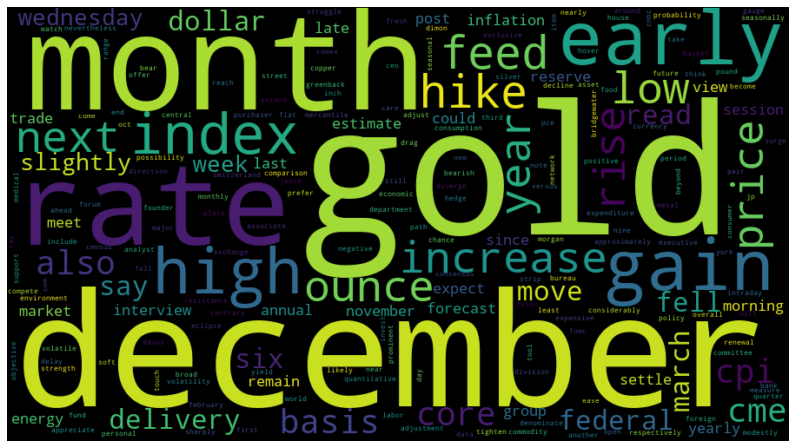

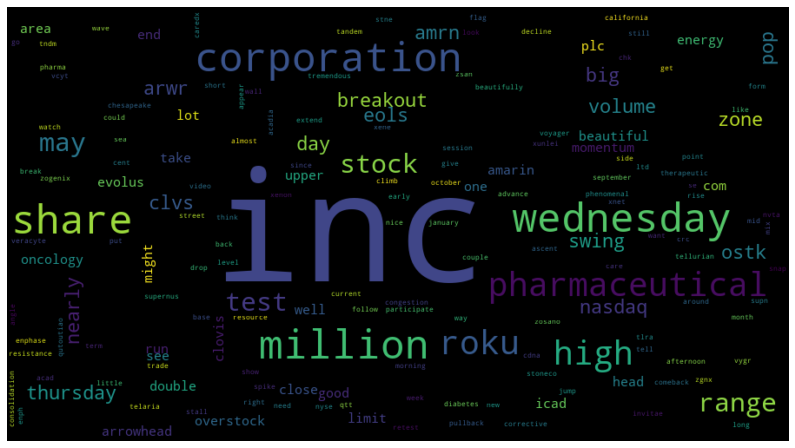

[None, None]

In [ ]:
estimators = [('p_word_tokenizer', pipelinize(p_word_tokenizer)),
              ('p_only_letters', pipelinize(p_only_letters)),
              ('p_remove_stopwords', pipelinize(p_remove_stopwords)),
              ('p_word_lemmatizer', pipelinize(p_word_lemmatizer)),
              ('p_count_vectorizer', pipelinize(p_count_vectorizer)),
              ('p_word_cloud_cv', pipelinize(p_word_cloud_cv))]

new_df_news = df_news.copy()

#Graficamos la nube de palabras de la primer noticia de nuestro sample df_news:
Pipeline(estimators).transform(new_df_news.content.values[:2])

En la primera noticia vemos que la palabra que más se repite es didi, la buscamos y es una compañía de transporte china Didi Chuxing Technology que proporciona vehículos y taxis de alquiler a través de aplicaciones y teléfonos inteligentes. A partir de las otras palabras que se observan se puede deducir que la noticia ronda en torno a dicha empresa y sector.

En la segunda noticia podemos observar a partir de las palabras más frecuentes que claramente es una noticia financiera que está relacionada a los juegos, juegos nintendo, de consola, tipo pokemon, mario.

##- Links y librerias utiles

https://www.nltk.org/

https://towardsdatascience.com/text-cleaning-methods-for-natural-language-processing-f2fc1796e8c7

https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76

https://www.linkedin.com/pulse/count-vectorizers-vs-tfidf-natural-language-processing-sheel-saket

https://towardsdatascience.com/3-basic-approaches-in-bag-of-words-which-are-better-than-word-embeddings-c2cbc7398016

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html